# Loan Prediction Model

In [1]:
import numpy as np
import pandas as pd
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv(r'Data\fannie_cleaned.csv')

C:\Users\samvi\AppData\Local\Temp\ipykernel_54504\2984769409.py:1: DtypeWarning: Columns (12,19,26,29,32,33,34,35,36,37,38,39,40,46,49,51,53,54,55,56,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'Data\fannie_cleaned.csv')


In [13]:
df['state'] = df['state'].replace('Current', np.nan)
df['Original UPB'] = (
    df['Original UPB']
    .str.replace('[\$,]', '', regex=True)  # remove $ and commas
    .astype(float)
)
df['UPB - Current'] = (
    df['UPB - Current']
    .str.replace('[\$,]', '', regex=True)  # remove $ and commas
    .astype(float)
)
df['Note Rate'] = df['Note Rate'].astype(float)

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
C:\Users\samvi\AppData\Local\Temp\ipykernel_54504\2843689772.py:4: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('[\$,]', '', regex=True)  # remove $ and commas
C:\Users\samvi\AppData\Local\Temp\ipykernel_54504\2843689772.py:9: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('[\$,]', '', regex=True)  # remove $ and commas


In [14]:
pd.set_option('display.max_columns', None)
df.head()

,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,start,stop,state,event_time
0,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,1.0,7.65,2009-12-01,14725385.83,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0,1,NaN,NaN
1,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,1.0,7.65,2009-12-01,14714704.00,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,1,2,NaN,NaN
2,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-01,1.0,7.65,2009-12-01,14703954.09,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,2,3,NaN,NaN
3,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-01,1.0,7.65,2009-12-01,14693135.65,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,3,4,NaN,NaN
4,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-05-01,1.0,7.65,2009-12-01,14682248.26,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,4,5,NaN,NaN


In [15]:
#Reducing size for testing

random_loans = df['Loan Number'].dropna().unique()
random_loans = pd.Series(random_loans).sample(n=1000, random_state=42)  # optional random_state for reproducibility
df_random = df[df['Loan Number'].isin(random_loans)]
df = df_random

In [16]:
columns_to_keep = ['Loan Number', 'start', 'stop', 'state', 'Loan Acquisition LTV', 'Original UPB', 'Note Rate']
df = df[columns_to_keep]

In [17]:
df['state'].value_counts()

state
Fully Paid, Prepaid    543
Default                370
Fully Paid, Matured     41
Foreclosure              7
Name: count, dtype: int64

In [18]:
target_states = ['Fully Paid, Prepaid', 'Default', 'Fully Paid, Matured', 'Foreclosure'] 

# For each event type, make a copy with a new column saying whether that event occurred
frames = []
for event in target_states:
    df_copy = df.copy()
    df_copy['event_type'] = event
    df_copy['event_occurred'] = (df_copy['state'] == event).astype(int)
    frames.append(df_copy)

# Concatenate all versions together
df_multi = pd.concat(frames, ignore_index=True)
df = df_multi

In [19]:
df

,Loan Number,start,stop,state,Loan Acquisition LTV,Original UPB,Note Rate,event_type,event_occurred
0,1674053544,0,1,NaN,83.0,2100000.0,8.50,"Fully Paid, Prepaid",0
1,1674053544,1,2,NaN,83.0,2100000.0,8.50,"Fully Paid, Prepaid",0
2,1674053544,2,3,NaN,83.0,2100000.0,8.50,"Fully Paid, Prepaid",0
3,1674053544,3,4,NaN,83.0,2100000.0,8.50,"Fully Paid, Prepaid",0
4,1674053544,4,5,NaN,83.0,2100000.0,8.50,"Fully Paid, Prepaid",0
...,...,...,...,...,...,...,...,...,...
297223,8300007853,110,111,NaN,39.9,9300000.0,5.87,Foreclosure,0
297224,8300007853,111,112,NaN,39.9,9300000.0,5.87,Foreclosure,0
297225,8300007853,112,113,NaN,39.9,9300000.0,5.87,Foreclosure,0
297226,8300007853,113,114,NaN,39.9,9300000.0,5.87,Foreclosure,0


In [20]:
unique_ids = df['Loan Number'].dropna().unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

In [21]:
models = {}

event_types = df['event_type'].dropna().unique()

for event in event_types:
    print(f"\n=== Training model for event: {event} ===")

    # Step 2: Create event_occurred_binary column
    df_event = df.copy()
    df_event = df_event.rename(columns={'Loan Number': 'id'})
    df_event['event_occurred_binary'] = (
        (df_event['event_occurred'] == 1) & (df_event['event_type'] == event)
    ).astype(int)

    df_event['id'] = df_event['id'].astype(str)
    train_df = df_event[df_event['id'].isin(train_ids)]
    test_df = df_event[df_event['id'].isin(test_ids)]

    print(f"✅ Added event_occurred_binary (sum: {df_event['event_occurred_binary'].sum()})")


    numeric_cols = df_event.select_dtypes(include=['number']).columns
    excluded = ['start', 'stop', 'event_occurred', 'event_occurred_binary']
    feature_cols = [col for col in numeric_cols if col not in excluded]

    final_cols = ['start', 'stop', 'event_occurred_binary'] + [col for col in feature_cols if col != 'id']
    final_cols = ['id'] + final_cols  # ensure id is added only once, in the right spot

    df_model_input = train_df[final_cols].dropna()
    if df_model_input['event_occurred_binary'].sum() == 0:
        continue

    print("⏳ Fitting model...")
    ctv = CoxTimeVaryingFitter()
    ctv.fit(
        df_model_input,
        id_col='id',
        start_col='start',
        stop_col='stop',
        event_col='event_occurred_binary',
        show_progress=True
    )

    models[event] = ctv


=== Training model for event: Fully Paid, Prepaid ===
✅ Added event_occurred_binary (sum: 543)

=== Training model for event: Default ===
✅ Added event_occurred_binary (sum: 370)

=== Training model for event: Fully Paid, Matured ===
✅ Added event_occurred_binary (sum: 41)

=== Training model for event: Foreclosure ===
✅ Added event_occurred_binary (sum: 7)


In [22]:
test_input = test_df[final_cols].dropna()
test_input['id'] = test_input['id'].astype(str)

# Make sure model is trained for this event
if event in models:
    ctv = models[event]
    
    # Predict partial hazards or survival
    try:
        partial_hazards = ctv.predict_partial_hazard(test_input)
        
        # Concordance Index
        from lifelines.utils import concordance_index
        c_index = concordance_index(
            test_input['stop'],
            -partial_hazards,  # negative for hazard to survival mapping
            event_observed=test_input['event_occurred_binary']
        )
        print(f"🔍 Concordance Index for {event}: {c_index:.4f}")

    except Exception as e:
        print(f"⚠️ Error testing model for {event}: {e}")

In [55]:
model = models['Default']
partial_hazard = model.predict_partial_hazard(test_loan_df)

print(partial_hazard.head())

plt.plot(test_loan_df['stop'].values, partial_hazard.values.flatten())
plt.xlabel("Month")
plt.ylabel("Partial hazard (relative risk)")
plt.title(f"Relative Risk Over Time for Loan {test_loan_id}")
plt.grid(True)
plt.show()

KeyError: "['Original UPB'] not in index"

In [17]:
event_mapping = {
    'Current': 0,
    'Fully Paid, Prepaid': 1,
    'Default': 2,
    'Fully Paid, Matured': 3,
    'Foreclosure': 4
}
df['event_code'] = df['state'].map(event_mapping)

In [19]:
# Check for any NaNs
nan_counts = df_event.isna().sum()
nan_cols = nan_counts[nan_counts > 0]

# Check for any infs
inf_counts = ((df_event == np.inf) | (df_event == -np.inf)).sum()
inf_cols = inf_counts[inf_counts > 0]

print("\n❗ Columns with NaNs:")
print(nan_cols)

print("\n❗ Columns with Infs:")
print(inf_cols)


❗ Columns with NaNs:
Series([], dtype: int64)

❗ Columns with Infs:
Series([], dtype: int64)


In [20]:
print("\n🔍 Constant columns:")
print(df_event.loc[:, df_event.nunique() <= 1].columns.tolist())


🔍 Constant columns:
['event_code']


In [18]:
event_codes = df_multi['event_code'].unique()
models = {}

for code in sorted(event_codes):
    print(f"\n=== Training model for event code: {code} ===")

    df_event = df_multi[df_multi['event_code'] == code].copy()

    if df_event['event_occurred'].sum() == 0:
        print(f"⚠️ No events occurred for code {code}. Skipping...")
        continue

    # Drop non-numeric columns except required ones
    numeric_cols = df_event.select_dtypes(include=['number']).columns.tolist()
    keep_cols = ['Loan Number', 'start', 'stop', 'event_occurred']
    final_cols = list(set(keep_cols).union(set(numeric_cols)))
    df_event = df_event[final_cols].copy()

    # Fit model
    ctv = CoxTimeVaryingFitter()
    ctv.fit(df_event,
            id_col='Loan Number',
            start_col='start',
            stop_col='stop',
            event_col='event_occurred',
            show_progress=True)

    models[code] = ctv
    ctv.print_summary()


=== Training model for event code: 0 ===


c:\Users\samvi\Documents\Coding Projects\Embedded Work\.venv\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['event_code'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


ConvergenceError: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs

<Figure size 1000x600 with 0 Axes>

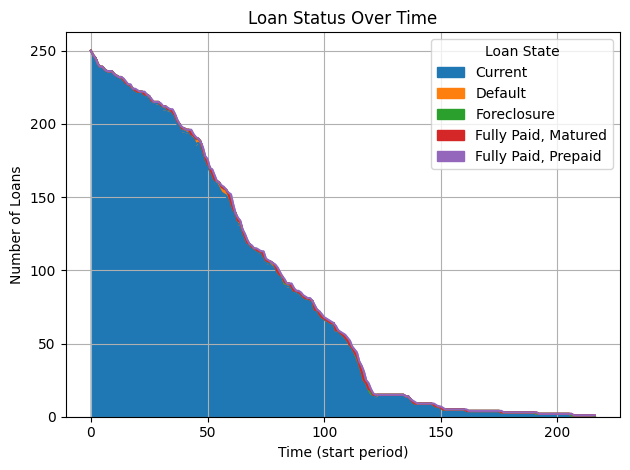

In [11]:
timeline_counts = df_random.groupby(['start', 'state']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
timeline_counts.plot(kind='area', stacked=True)

plt.title('Loan Status Over Time')
plt.xlabel('Time (start period)')
plt.ylabel('Number of Loans')
plt.legend(title='Loan State')
plt.grid(True)
plt.tight_layout()
plt.show()